In [1]:
import os
import zipfile
import urllib

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from fiona.crs import from_epsg

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble  import RandomForestClassifier as rfc
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import pylab as pl
import matplotlib.pylab as plt
from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# FHV

In [2]:
fhv = pd.read_csv("output_fhv/fhv.csv")
nrow_fhv = fhv.shape[0]
print(fhv.shape)
fhv.head()

(12899039, 4)


date  PUlocationID  DOlocationID  count
0  2015-01-01             0             0  10574
1  2015-01-03             0             0  13391
2  2015-01-04             0             0  13173
3  2015-01-13             0             0  21628
4  2015-01-15             0             0  24166

In [3]:
fhv.tail()

date  PUlocationID  DOlocationID  count
12899034  2018-06-08           263            71      1
12899035  2018-06-06           174            14      1
12899036  2018-06-06           232           174      1
12899037  2018-06-29            20            25      1
12899038  2018-06-20           158            10      1

## outlier delete: done when cleaning with spark

def outlier_delete(x):
    if x in range(1,264):
        return x
    else:
        return 0

%%time
fhv['PUlocationID'] = fhv['PUlocationID'].apply(outlier_delete)
fhv['DOlocationID'] = fhv['DOlocationID'].apply(outlier_delete)

print("valid PUlocationID: ", len(fhv[fhv['PUlocationID']>=1])/nrow_fhv)
print("valid DOlocationID: ", len(fhv[fhv['DOlocationID']>=1])/nrow_fhv)

%%time
fhv.to_csv("output_fhv/fhv.csv")

sorted(fhv['PUlocationID'].unique())

sorted(fhv['DOlocationID'].unique())

## time series analysis

### time stamp conversion

In [4]:
fhv["date"] = pd.to_datetime(fhv["date"],format='%Y-%m-%d')
print(type(fhv["date"][0]))
fhv["date"][0]

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Timestamp('2015-01-01 00:00:00')

In [5]:
dates = fhv[['date']].drop_duplicates().sort_values(by='date').reset_index(drop=True)
print(dates.shape)
dates.head()

(1277, 1)


date
0 2015-01-01
1 2015-01-02
2 2015-01-03
3 2015-01-04
4 2015-01-05

In [6]:
dates.tail()

date
1272 2018-06-26
1273 2018-06-27
1274 2018-06-28
1275 2018-06-29
1276 2018-06-30

### daily overall activities

In [7]:
fhv_daily = fhv.groupby('date').sum()[['count']].sort_index()
fhv_daily.head()

count
date             
2015-01-01  77789
2015-01-02  61832
2015-01-03  81955
2015-01-04  62691
2015-01-05  71063

In [8]:
fhv_daily.shape[0]

1277

Text(0.5, 1.0, 'time series for the number of daily fhv activities')

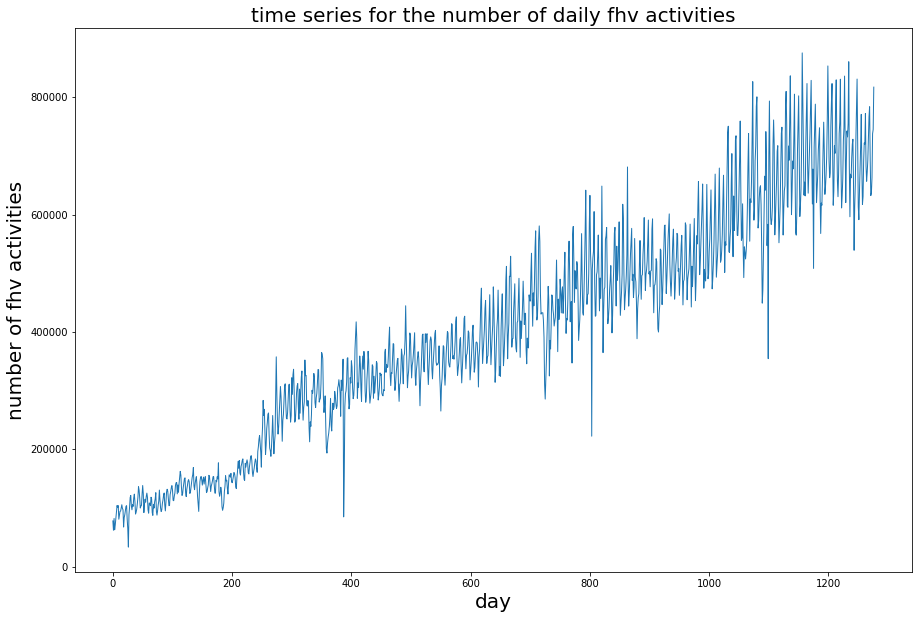

In [9]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(fhv_daily.shape[0]), fhv_daily['count'], '-', linewidth=1)
ax.set_ylabel('number of fhv activities', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('time series for the number of daily fhv activities', fontsize=20)

### daily pickup

In [10]:
# daily sum
fhv_pickup = fhv.groupby(['date', 'PUlocationID']).sum()\
                .sort_index().reset_index()[['date', 'PUlocationID', 'count']]
print(fhv_pickup.shape)
fhv_pickup.head()

(329040, 3)


date  PUlocationID  count
0 2015-01-01             0  13266
1 2015-01-01             1      1
2 2015-01-01             2      3
3 2015-01-01             3     29
4 2015-01-01             4    455

In [11]:
# daily mean
fhv_pickup_mean = fhv_pickup.groupby(['date']).mean()\
                .reset_index()[['date', 'count']]
print(fhv_pickup_mean.shape)
fhv_pickup_mean.head()

(1277, 2)


date       count
0 2015-01-01  308.686508
1 2015-01-02  253.409836
2 2015-01-03  323.932806
3 2015-01-04  255.881633
4 2015-01-05  290.053061

Wall time: 4.66 s


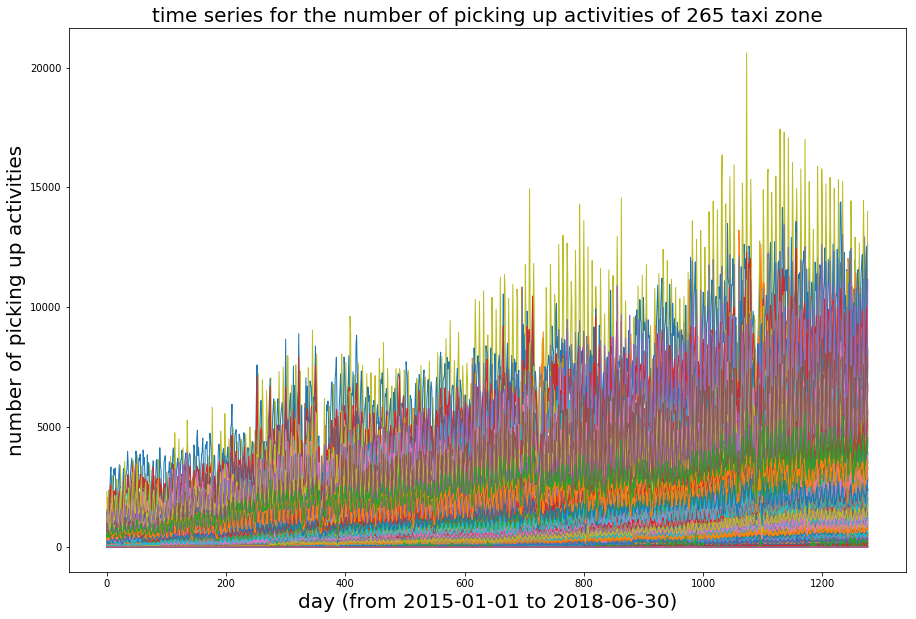

In [12]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(1,266):    
    num_days = len(fhv_pickup['date'].unique())    
    count_deficient = fhv_pickup[fhv_pickup['PUlocationID']==i]
    count = pd.merge(dates,count_deficient, on='date', how='outer').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1)
ax.set_ylabel('number of picking up activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of picking up activities of 265 taxi zone', fontsize=20)

Wall time: 4.68 s


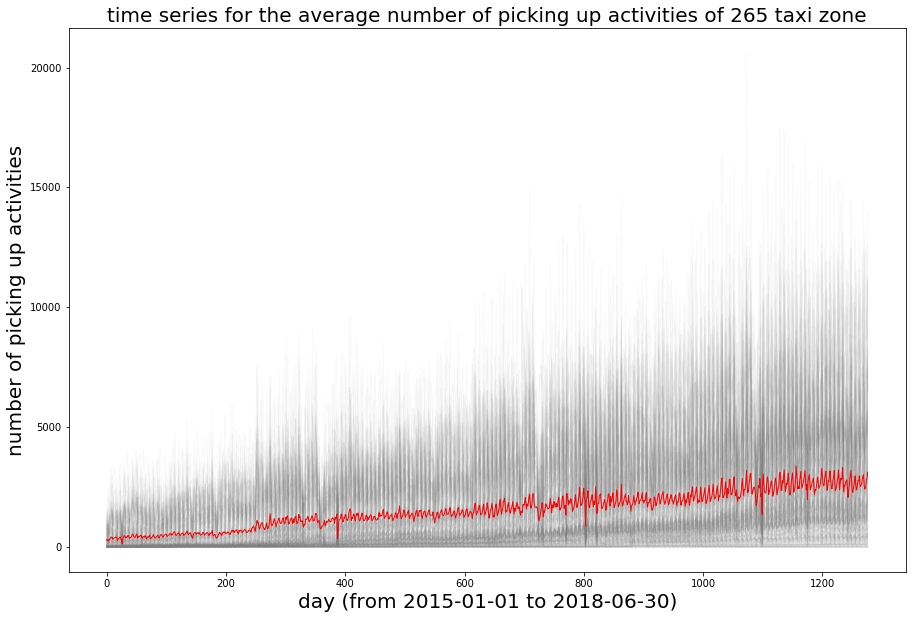

In [13]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(1,266):    
    num_days = len(fhv_pickup['date'].unique())    
    count_deficient = fhv_pickup[fhv_pickup['PUlocationID']==i]
    count = pd.merge(dates,count_deficient, on='date', how='outer').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1, alpha=0.05, color='grey')
ax.plot(range(num_days), fhv_pickup_mean['count'], '-', linewidth=1, alpha=1, color='r')
ax.set_ylabel('number of picking up activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the average number of picking up activities of 265 taxi zone', fontsize=20)

### daily dropoff

In [14]:
fhv_dropoff = fhv.groupby(['date', 'DOlocationID']).sum()\
                .sort_index().reset_index()[['date', 'DOlocationID', 'count']]
print(fhv_dropoff.shape)
fhv_dropoff.head()

(107100, 3)


date  DOlocationID  count
0 2015-01-01             0  77789
1 2015-01-02             0  61832
2 2015-01-03             0  81955
3 2015-01-04             0  62691
4 2015-01-05             0  71063

In [15]:
fhv_dropoff.tail()

date  DOlocationID  count
107095 2018-06-30           259   1613
107096 2018-06-30           260   3276
107097 2018-06-30           261   2498
107098 2018-06-30           262   2439
107099 2018-06-30           263   4132

In [16]:
fhv_dropoff_mean = fhv_dropoff[fhv_dropoff['DOlocationID']!=0].groupby(['date']).mean()\
                .reset_index()[['date', 'count']]
fhv_dropoff_mean = pd.merge(dates, fhv_dropoff_mean, on='date', how='left').fillna(0)
print(fhv_dropoff_mean.shape)
fhv_dropoff_mean.head()

(1277, 2)


date  count
0 2015-01-01    0.0
1 2015-01-02    0.0
2 2015-01-03    0.0
3 2015-01-04    0.0
4 2015-01-05    0.0

fhv_dropoff_mean = fhv_dropoff.groupby(['date']).mean()\
                .reset_index()[['date', 'count']]
fhv_dropoff_mean = pd.merge(dates, fhv_dropoff_mean, on='date', how='left').fillna(0)
print(fhv_dropoff_mean.shape)
fhv_dropoff_mean.head()

Wall time: 3.33 s


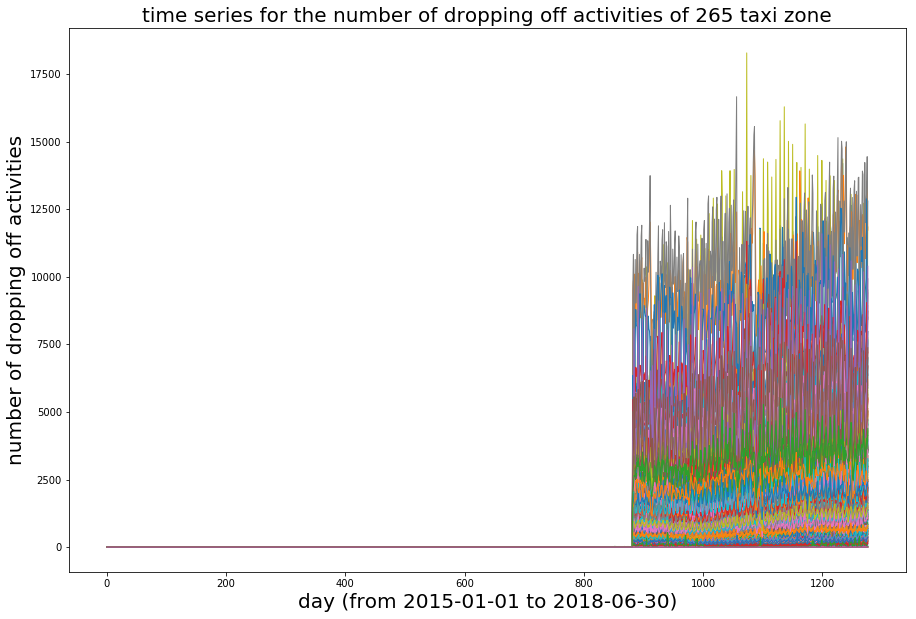

In [17]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(1,266):    
    num_days = len(fhv_dropoff['date'].unique())    
    count_deficient = fhv_dropoff[fhv_dropoff['DOlocationID']==i]
    count = pd.merge(dates,count_deficient, on='date', how='outer').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1)
ax.set_ylabel('number of dropping off activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of dropping off activities of 265 taxi zone', fontsize=20)

Wall time: 3.17 s


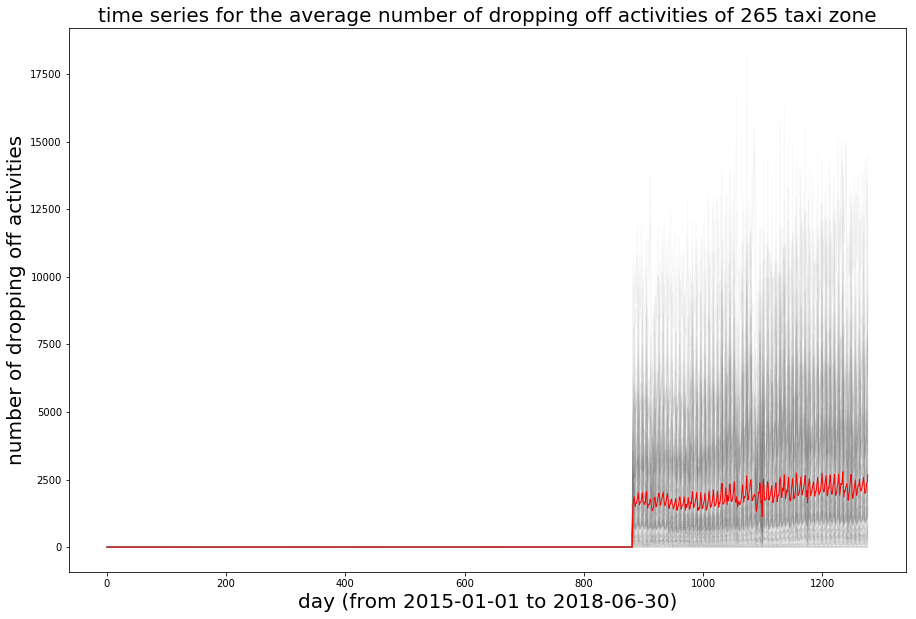

In [18]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(1,266):    
    num_days = len(fhv_dropoff['date'].unique())    
    count_deficient = fhv_dropoff[fhv_dropoff['DOlocationID']==i]
    count = pd.merge(dates,count_deficient, on='date', how='outer').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1, alpha=0.05, color='grey')

ax.plot(range(num_days), fhv_dropoff_mean['count'], '-', linewidth=1, alpha=1, color='r')

ax.set_ylabel('number of dropping off activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the average number of dropping off activities of 265 taxi zone', fontsize=20)

### outlier detection

**The mean and stardand deviation of the time series can be used to set a 3-sigma threshold**  
**every value that is more then 3 sigmas away from the mean can be flagged as an event**

In [19]:
outlier = fhv_dropoff[fhv_dropoff['date']==fhv_dropoff['date'][len(fhv_dropoff)-1]]
outlier = outlier[outlier['count']== outlier['count'].max()]
DOlocationID_outlier = int(outlier['DOlocationID'])
print("The DOlocationID_outlier is:", DOlocationID_outlier)

The DOlocationID_outlier is: 0


## taxi zones geometry

In [20]:
if not os.path.isfile("taxi_zones/taxi_zones.shp"):    
    !curl https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip > taxi_zones.zip
    !mv taxi_zones.zip taxi_zones
    !unzip -o taxi_zones/taxi_zones.zip -d taxi_zones
else:
    print("file in place, you can continue")

file in place, you can continue


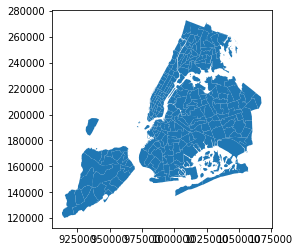

In [21]:
taxi_zones = gpd.read_file("taxi_zones/taxi_zones.shp")
taxi_zones.plot()

In [22]:
print(taxi_zones.shape)
taxi_zones.head()

(263, 7)


OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.9183527103 192536.0856972019,...  
1         Queens  (POLYGON ((1033269.243591294 172126.0078125, 1...  
2          Bronx  POLYGON ((1026308.769506663 256767.6975403726,...  
3      Manhattan  POLYGON ((992073.4667968601 203714.0759887695,...  
4  Staten Island  POLYGON ((935843.3104932606 144283.335850656, ...

http://geopandas.org/reference.html  
legend_kwds : dict (default None)  
Keyword arguments to pass to ax.legend()

### overall

### pick up

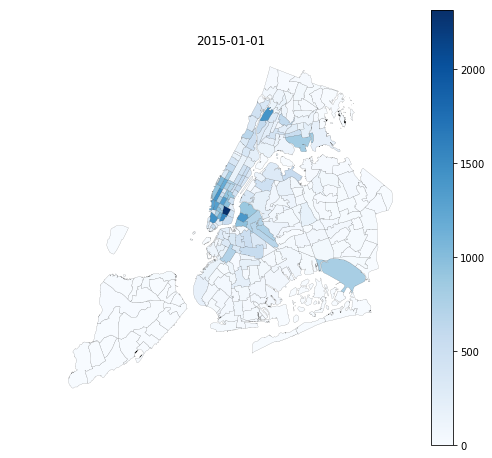

In [23]:
# plot the choropleth of the first day
date = dates['date'][0]
fhv_pickup_plot = fhv_pickup[fhv_pickup['date']==date]
taxi_zones_plot = pd.merge(taxi_zones, fhv_pickup_plot, left_on = 'LocationID', right_on = 'PUlocationID', how='left')

fig, ax = plt.subplots(figsize=(8, 8))
taxi_zones_plot.fillna(0).plot(column = 'count', cmap='Blues', linewidth=0.1, ax=ax, edgecolor='black', legend=True)
ax.set_axis_off()
plt.title(str(date)[:10])

fig.savefig('png_pickup/'+str(date)[:10])


#### GIF
%%time
for i in dates['date']:
    date = i
    fhv_pickup_plot = fhv_pickup[fhv_pickup['date']==date]
    taxi_zones_plot = pd.merge(taxi_zones, fhv_pickup_plot, left_on = 'LocationID', right_on = 'PUlocationID', how='left')

    fig, ax = plt.subplots(figsize=(8, 8))
    taxi_zones_plot.fillna(0).plot(column = 'count', cmap='Blues', linewidth=0.1, ax=ax, edgecolor='black', legend=True)
    ax.set_axis_off()
    plt.title(str(date)[:10])

    fig.savefig('png_pickup/'+str(date)[:10])

### drop off

# Tickets

## time series analysis

### time stamp conversion

In [24]:
tickets = pd.read_csv("output_tickets_zone/tickets_zone.csv")
print(tickets.shape)
tickets.head()

(564772, 3)


date  zone  count
0  08/13/2000    60      1
1  08/18/2000   135      1
2  10/02/2000   141      1
3  10/04/2000   165      1
4  10/15/2000   248      1

In [25]:
tickets["date"] = pd.to_datetime(tickets["date"],format='%m/%d/%Y')
tickets = tickets.sort_values(by = 'date')

tickets = tickets[tickets['date'].isin(dates['date'])]

# data from different year may contains the row of the same date 
tickets = tickets.groupby(['date','zone']).sum().reset_index()

print(tickets.shape)
tickets.head()

(316666, 3)


date  zone  count
0 2015-01-01     1     10
1 2015-01-01     2     75
2 2015-01-01     4     43
3 2015-01-01     5      6
4 2015-01-01     6     22

In [26]:
tickets.tail()

date  zone  count
316661 2018-06-30   258     48
316662 2018-06-30   259     72
316663 2018-06-30   260      9
316664 2018-06-30   261      4
316665 2018-06-30   262    157

### daily overall tickets

In [27]:
# daily sum
tickets_daily = tickets.groupby('date').sum().reset_index()
print(tickets_daily.shape)
tickets_daily.head()

(1277, 3)


date   zone  count
0 2015-01-01  26530   5390
1 2015-01-02  32386  47811
2 2015-01-03  31237  24505
3 2015-01-04  27682   6834
4 2015-01-05  32888  55922

In [28]:
# daily mean
tickets_mean = tickets.groupby(['date']).mean()\
                .reset_index()[['date', 'count']]
print(tickets_mean.shape)
tickets_mean.head()

(1277, 2)


date       count
0 2015-01-01   27.222222
1 2015-01-02  195.946721
2 2015-01-03  103.396624
3 2015-01-04   32.698565
4 2015-01-05  225.491935

Text(0.5, 1.0, 'time series for the number of daily parking tickets')

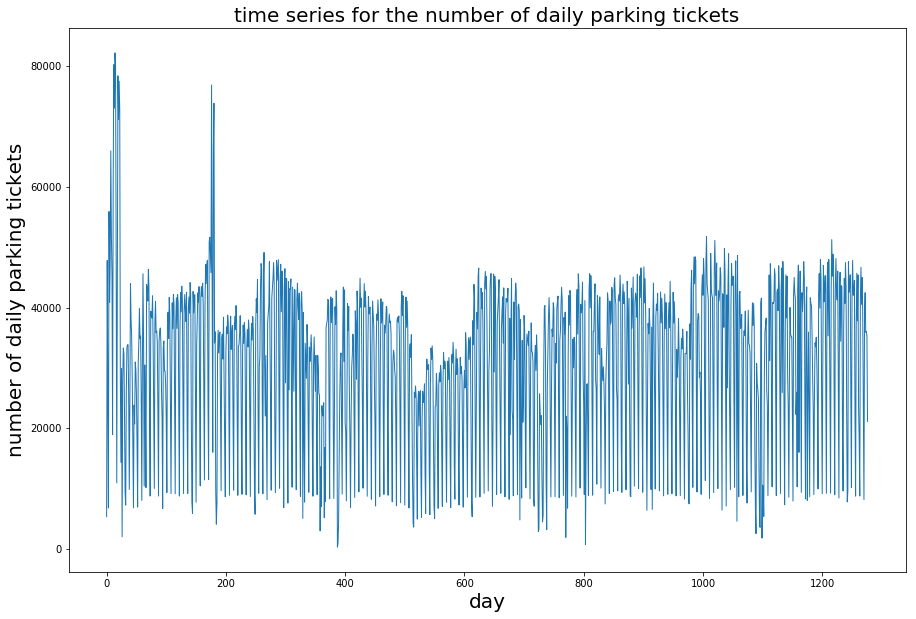

In [29]:
# daily sum plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
num_days = len(tickets_daily['date'].unique())
ax.plot(range(num_days), tickets_daily['count'], '-', linewidth=1)
ax.set_ylabel('number of daily parking tickets', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('time series for the number of daily parking tickets', fontsize=20)

### every taxi zone

Wall time: 2.95 s


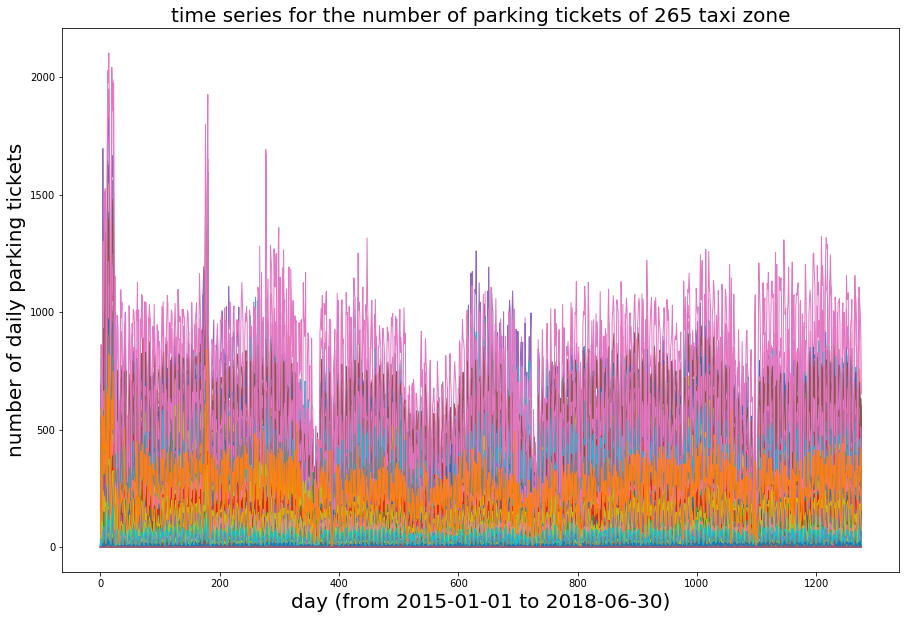

In [30]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

num_days = len(dates['date'].unique()) 
for i in range(1,266):   
    count_deficient = tickets[tickets['zone']==i]
    count = pd.merge(dates,count_deficient, on='date', how='left').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1)
ax.set_ylabel('number of daily parking tickets', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of parking tickets of 265 taxi zone', fontsize=20)

Wall time: 2.65 s


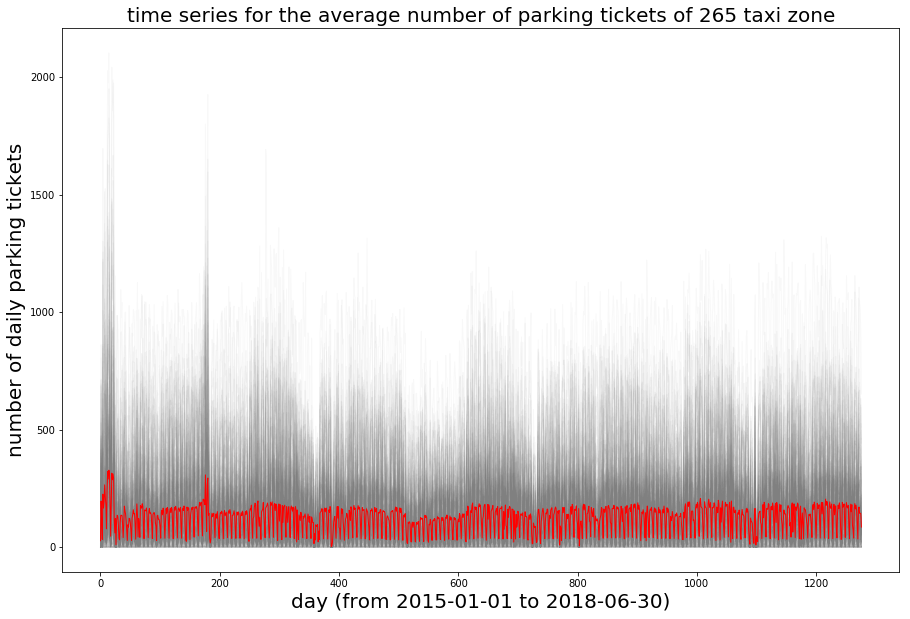

In [31]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

num_days = len(dates['date'].unique()) 
for i in range(1,266):   
    count_deficient = tickets[tickets['zone']==i]
    count = pd.merge(dates,count_deficient, on='date', how='left').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1, alpha=0.05, color='grey')
tickets_mean_reduced = pd.merge(dates,tickets_mean, on='date', how='left')
ax.plot(range(num_days), tickets_mean_reduced['count'], '-', linewidth=1, alpha=1, color='r')
ax.set_ylabel('number of daily parking tickets', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the average number of parking tickets of 265 taxi zone', fontsize=20)

# correlation analysis

## Merge all datesets

In [32]:
df = pd.merge(fhv_pickup, fhv_dropoff, left_on = ['date', 'PUlocationID'], right_on=['date', 'DOlocationID'], how='outer')
df['DOlocationID'].fillna(value = df['PUlocationID'], inplace=True)
df['PUlocationID'].fillna(value = df['DOlocationID'], inplace=True)
df.fillna(0, inplace=True)
df = df.drop(['DOlocationID'], axis=1)
df.columns = ['date', 'zone', 'pickup', 'dropoff']
print(df.shape)
df.head()

(329287, 4)


date  zone   pickup  dropoff
0 2015-01-01   0.0  13266.0  77789.0
1 2015-01-01   1.0      1.0      0.0
2 2015-01-01   2.0      3.0      0.0
3 2015-01-01   3.0     29.0      0.0
4 2015-01-01   4.0    455.0      0.0

In [33]:
df.tail()

date   zone  pickup  dropoff
329282 2018-06-27    2.0     0.0      2.0
329283 2018-06-27  104.0     0.0      1.0
329284 2018-06-27  105.0     0.0      1.0
329285 2018-06-28  105.0     0.0      2.0
329286 2018-06-29    2.0     0.0      1.0

In [34]:
df = pd.merge(df, tickets, left_on = ['date', 'zone'], right_on=['date', 'zone'], how='outer').fillna(0)
df.rename(columns={'count': 'tickets'}, inplace=True)
print(df.shape)
df.head()

(333872, 5)


date  zone   pickup  dropoff  tickets
0 2015-01-01   0.0  13266.0  77789.0      0.0
1 2015-01-01   1.0      1.0      0.0     10.0
2 2015-01-01   2.0      3.0      0.0     75.0
3 2015-01-01   3.0     29.0      0.0      0.0
4 2015-01-01   4.0    455.0      0.0     43.0

In [35]:
df.tail()

date   zone  pickup  dropoff  tickets
333867 2018-06-26  105.0     0.0      0.0     85.0
333868 2018-06-27  199.0     0.0      0.0     29.0
333869 2018-06-29  105.0     0.0      0.0     72.0
333870 2018-06-29  199.0     0.0      0.0     28.0
333871 2018-06-30  199.0     0.0      0.0     19.0

In [36]:
%%time
df.to_csv('output_final/date_final.csv', index=False)

Wall time: 7.11 s


## Correlation exploration

In [37]:
df['fhv'] = df['pickup'] + df['dropoff']
df.corr()

zone    pickup   dropoff   tickets       fhv
zone     1.000000 -0.073339 -0.089769 -0.000882 -0.087260
pickup  -0.073339  1.000000  0.890570 -0.031285  0.940296
dropoff -0.089769  0.890570  1.000000 -0.040014  0.992210
tickets -0.000882 -0.031285 -0.040014  1.000000 -0.038511
fhv     -0.087260  0.940296  0.992210 -0.038511  1.000000

%%time
### correlation matrix: sfig = pd.scatter_matrix(df, s=30, figsize=(10, 10), diagonal='kde')
sfig = pd.plotting.scatter_matrix(df, s=30, figsize=(10, 10), diagonal='kde')

### Time series plot

In [39]:
tickets_daily_reduced = pd.merge(dates,tickets_daily, on='date', how='left')

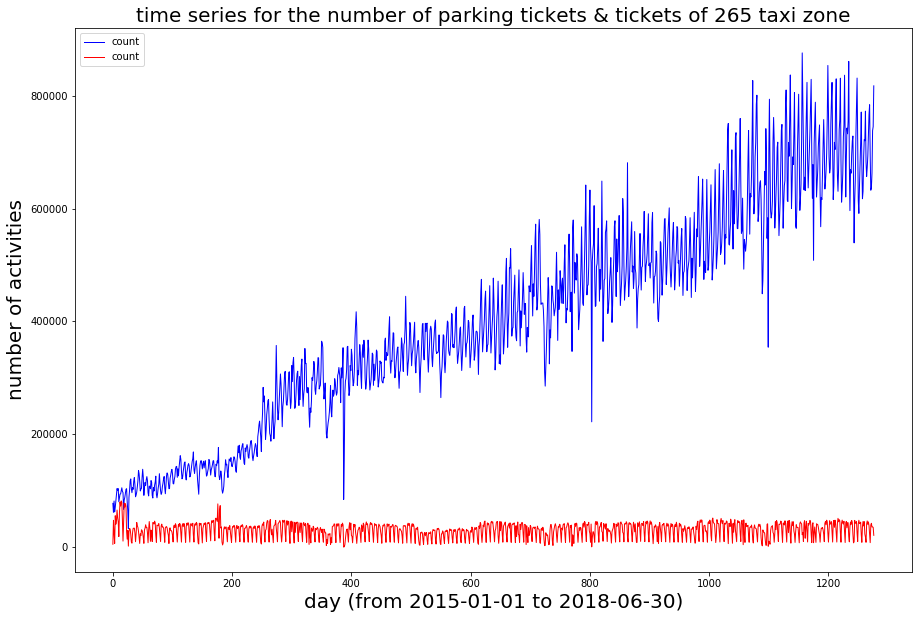

In [41]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(fhv_daily.shape[0]), fhv_daily['count'], '-', linewidth=1, color='b')
ax.plot(range(fhv_daily.shape[0]), tickets_daily_reduced['count'], '-', linewidth=1, color='r')

ax.set_ylabel('number of activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of parking tickets & tickets of 265 taxi zone', fontsize=20)
ax.legend()

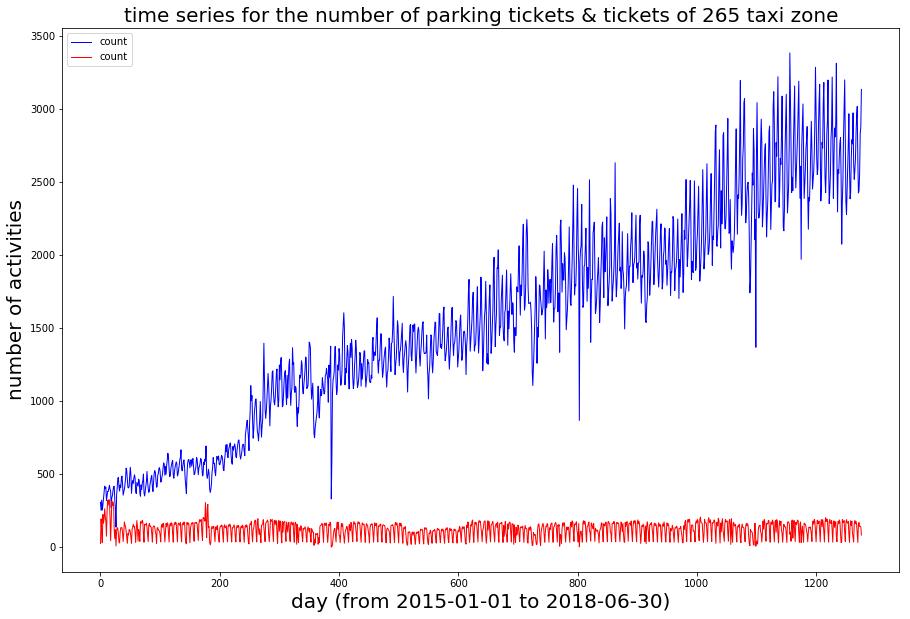

In [61]:

tickets_mean_reduced = pd.merge(dates,tickets_mean, on='date', how='left')

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(fhv_pickup_mean.shape[0]), fhv_pickup_mean['count'], '-', linewidth=1, color='b')
ax.plot(range(fhv_pickup_mean.shape[0]), tickets_mean_reduced['count'], '-', linewidth=1, color='r')

ax.set_ylabel('number of activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of parking tickets & tickets of 265 taxi zone', fontsize=20)
ax.legend()

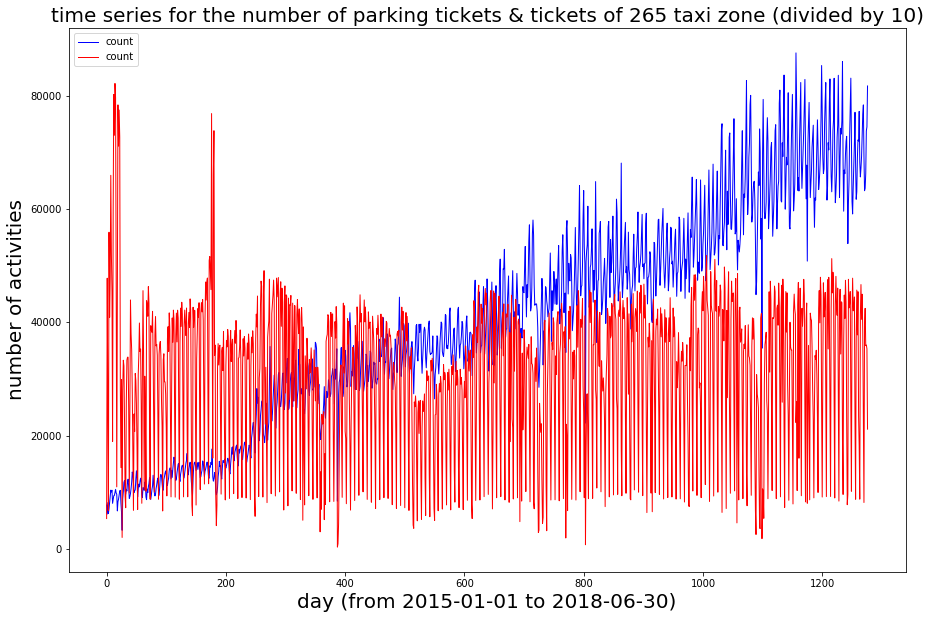

In [43]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(fhv_daily.shape[0]), fhv_daily['count']/10, '-', linewidth=1, color='b')
ax.plot(range(fhv_daily.shape[0]), tickets_daily_reduced['count'], '-', linewidth=1, color='r')

ax.set_ylabel('number of activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of parking tickets & tickets of 265 taxi zone (divided by 10)', fontsize=20)
ax.legend()

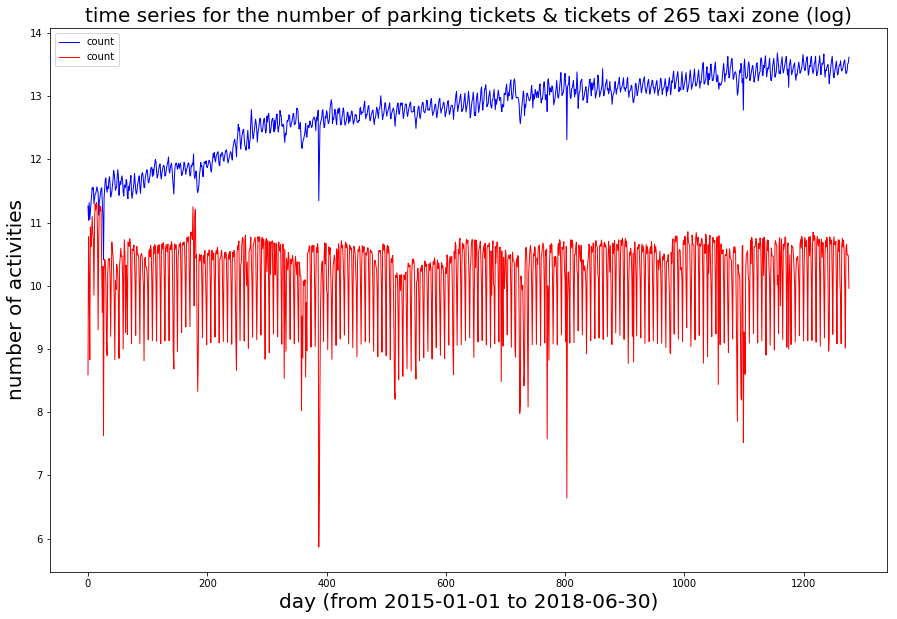

In [44]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(fhv_daily.shape[0]), np.log(fhv_daily['count']), '-', linewidth=1, color='b')
ax.plot(range(fhv_daily.shape[0]), np.log(tickets_daily_reduced['count']), '-', linewidth=1, color='r')

ax.set_ylabel('number of activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of parking tickets & tickets of 265 taxi zone (log)', fontsize=20)
ax.legend()

### 265 pairs of lines for FHV pick up and tickets

Wall time: 35.9 ms


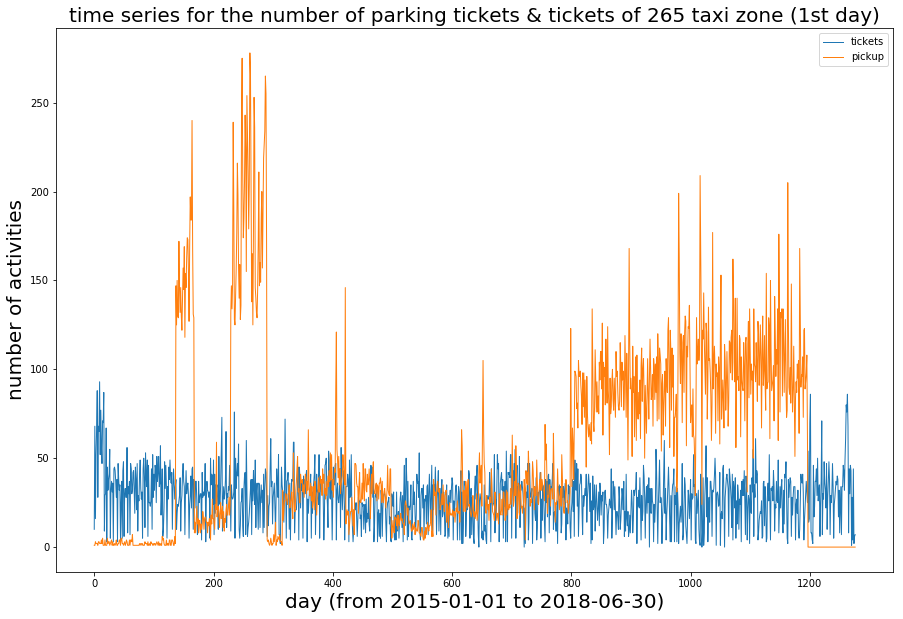

In [47]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

num_days = len(dates['date'].unique()) 

i=1
ax.plot(range(num_days), df[df['zone']==i]['tickets'], '-', linewidth=1)
ax.plot(range(num_days), df[df['zone']==i]['pickup'], '-', linewidth=1)

ax.set_ylabel('number of activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of parking tickets & tickets of 265 taxi zone (1st day)', fontsize=20)
ax.legend()

Wall time: 3.77 s


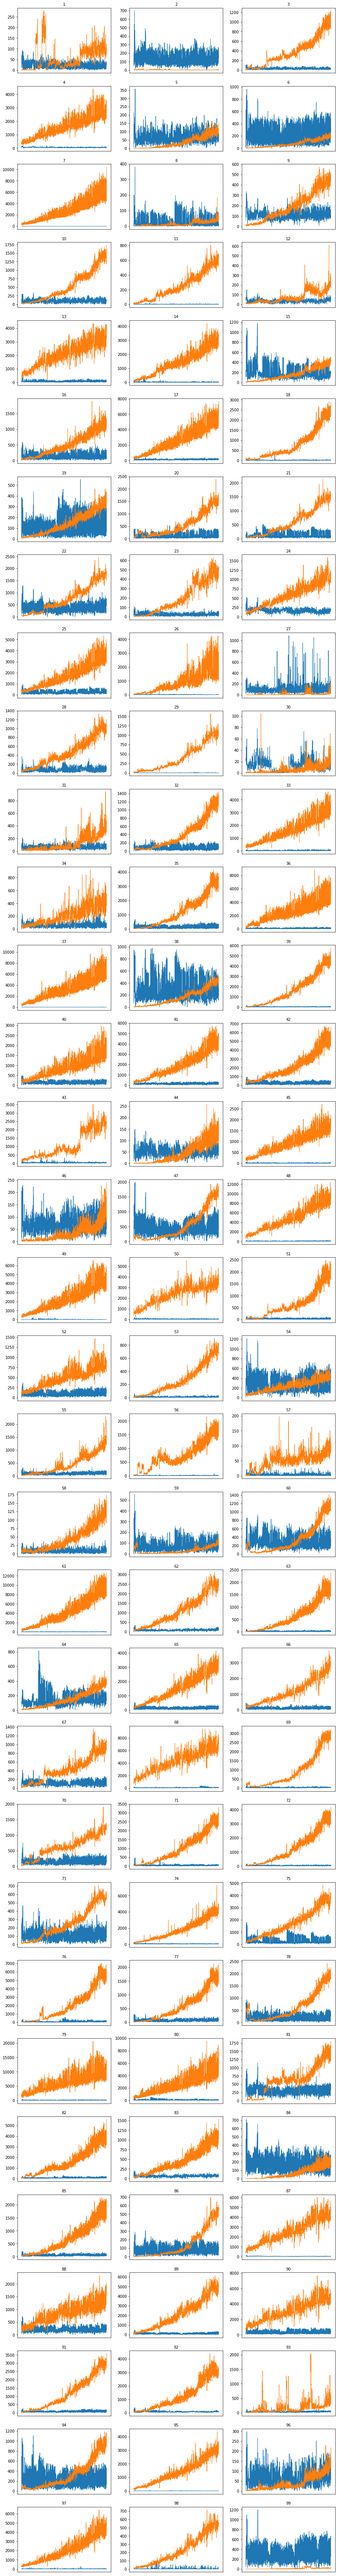

In [48]:
%%time

# Zone 1-99
fig = plt.figure(figsize=(15,200))
num_days = len(dates['date'].unique()) 

for i in range(1,100):
    ax = fig.add_subplot(53,3,i)
    temp = pd.merge(dates, df[df['zone']==i][['date', 'pickup', 'tickets']], how='left')
    ax.plot(range(num_days), temp['tickets'], '-', linewidth=1)
    ax.plot(range(num_days), temp['pickup'], '-', linewidth=1)
    ax.set_title(i, fontsize=10)
    ax.set_xticks([])    
    #ax.legend()

Wall time: 3.52 s


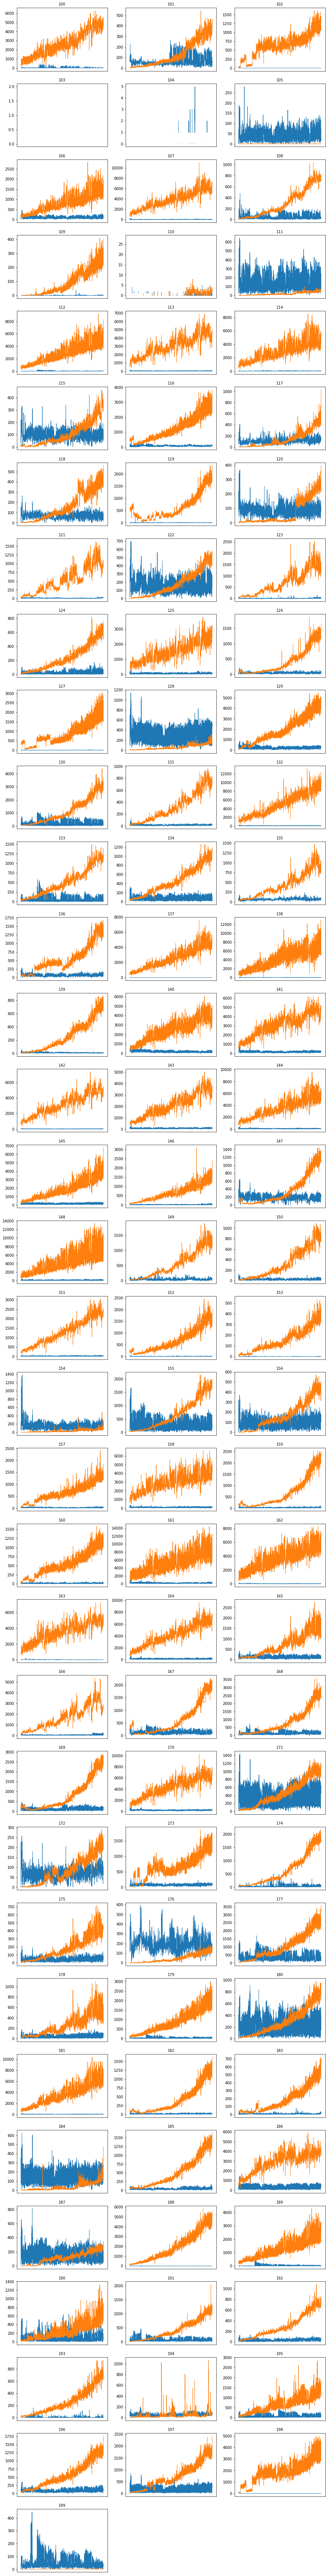

In [49]:
%%time

# Zone 100-199
fig = plt.figure(figsize=(15,200))
num_days = len(dates['date'].unique()) 

for i in range(100,200):
    ax = fig.add_subplot(53,3,i-99)
    temp = pd.merge(dates, df[df['zone']==i][['date', 'pickup', 'tickets']], how='left')
    ax.plot(range(num_days), temp['tickets'], '-', linewidth=1)
    ax.plot(range(num_days), temp['pickup'], '-', linewidth=1)
    ax.set_title(i, fontsize=10)
    ax.set_xticks([])
    #ax.legend()

Wall time: 2.41 s


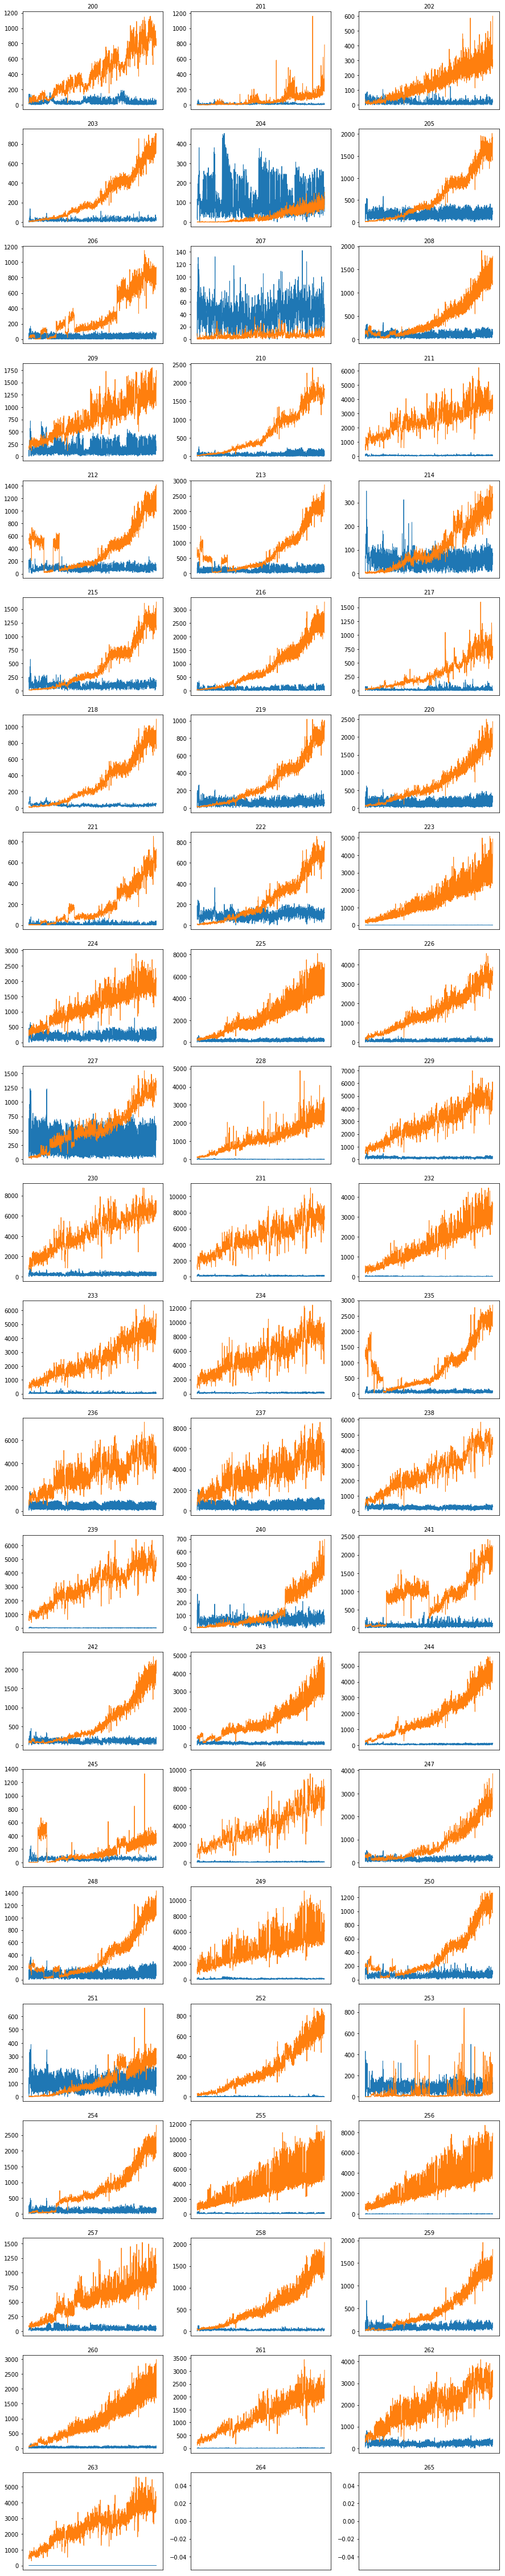

In [50]:
%%time

# Zone 199-265
fig = plt.figure(figsize=(15,200))
num_days = len(dates['date'].unique()) 

for i in range(200,266):
    ax = fig.add_subplot(53,3,i-199)
    temp = pd.merge(dates, df[df['zone']==i][['date', 'pickup', 'tickets']], how='left')
    ax.plot(range(num_days), temp['tickets'], '-', linewidth=1)
    ax.plot(range(num_days), temp['pickup'], '-', linewidth=1)
    ax.set_title(i, fontsize=10)
    ax.set_xticks([])
    #ax.legend()

## correlation clustering

### default correlation

In [51]:
corr_list = []
for i in range(1,264):    
    corr = df[df['zone']==i][['pickup', 'tickets']].corr()['tickets'][:1].values[0]
    corr_list.append(corr)
#corr_list

In [52]:
taxi_zones['correlation_default']=corr_list
taxi_zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.9183527103 192536.0856972019,...   
1         Queens  (POLYGON ((1033269.243591294 172126.0078125, 1...   
2          Bronx  POLYGON ((1026308.769506663 256767.6975403726,...   
3      Manhattan  POLYGON ((992073.4667968601 203714.0759887695,...   
4  Staten Island  POLYGON ((935843.3104932606 144283.335850656, ...   

   correlation_default  
0            -0.125212  
1            -0.048810  
2            -0.042325  
3            -0.150384  
4             0.086993

Text(0.5, 1.0, 'default correlation map')

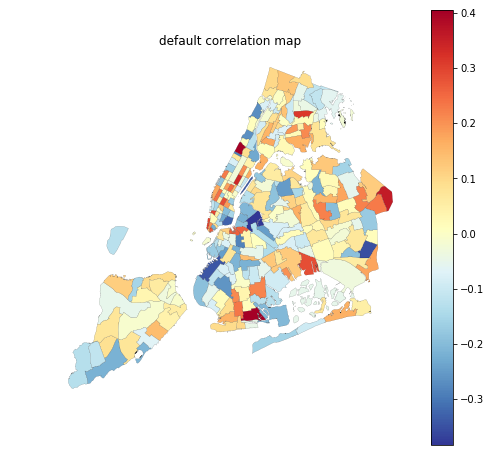

In [53]:
# cmap: https://matplotlib.org/tutorials/colors/colormaps.html
fig, ax = plt.subplots(figsize=(8, 8))
taxi_zones.fillna(0).plot(column = 'correlation_default', cmap='RdYlBu_r', linewidth=0.1, ax=ax, edgecolor='black', legend=True)
ax.set_axis_off()
plt.title("default correlation map")


### pearson

### spearman